# PC Boxes and Variables Automatization

## Imports and Functions

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
import os
from matplotlib.colors import ListedColormap, BoundaryNorm
from itertools import combinations

import sys
import seaborn as sns
import re

import cartopy.crs as ccrs
import cartopy.feature as cfeature



In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

c:\Users\marti\Desktop\data\hw_extra


In [3]:

from IndexDrivers import (
    MultivariatePCA, 
    plot_hw_index,
    plot_hw_index_by_season,
    scatter_color_year,
    scatter_color_season
)

In [4]:
def df_to_series(dataframe, name_series, years=[1979,2023]):
    selected = dataframe[(dataframe["Year"]< years[1]) & (dataframe["Year"] > years[0])]
    df_melted = selected.melt(id_vars=['Year'], var_name='Month', value_name=name_series)
    df_melted["Month"] = pd.to_numeric(df_melted["Month"])
    df_melted = df_melted.sort_values(['Year','Month'])

    df_melted['Date'] = pd.to_datetime(df_melted[['Year', 'Month']].assign(DAY=1))
    df_melted.set_index('Date', inplace=True)

    return df_melted.drop(columns=["Year", "Month"])

def plot_corr(dataframe, cols):
    sns.heatmap(dataframe.corr()[cols], cmap="coolwarm", annot=True)
    plt.show()

def compute_correlations(df, num_indices=5, method='pearson'):
    """
    Compute the correlation between the first `num_indices` columns and the rest of the columns in a DataFrame
    using the specified method (Pearson, Spearman, or Kendall).
    
    Parameters:
    - df: pd.DataFrame, the input DataFrame with timeseries as columns.
    - num_indices: int, number of columns to use as the principal indices for correlation.
    - method: str, the method for correlation ('pearson', 'spearman', 'kendall').
    
    Returns:
    - pd.DataFrame with correlations between the `num_indices` columns and the rest of the columns.
    """
    if method not in ['pearson', 'spearman', 'kendall']:
        raise ValueError("Method must be 'pearson', 'spearman', or 'kendall'")

    # Extract the first `num_indices` columns as principal indices
    principal_df = df.iloc[:, :num_indices]
    
    # Extract the rest of the columns
    other_df = df.iloc[:, num_indices:]
    
    # If method is not 'pearson', we need to use rank correlation methods
    if method == 'spearman':
        # Rank the data for Spearman correlation
        principal_df = principal_df.rank()
        other_df = other_df.rank()
    elif method == 'kendall':
        # Pandas `.corr()` will be used for Kendall to handle pairwise calculation
        return other_df.corrwith(principal_df, axis=0, method='kendall')
    
    # Compute correlation matrix using dot product for Pearson or Spearman
    principal_values = principal_df.values
    other_values = other_df.values
    
    # Mean-center the data
    principal_mean_centered = principal_values - principal_values.mean(axis=0)
    other_mean_centered = other_values - other_values.mean(axis=0)
    
    # Compute the standard deviations
    principal_std = principal_values.std(axis=0)
    other_std = other_values.std(axis=0)
    
    # Normalize data
    principal_normalized = principal_mean_centered / principal_std
    other_normalized = other_mean_centered / other_std
    
    # Compute the correlation matrix using dot product
    correlations = np.dot(other_normalized.T, principal_normalized) / (other_values.shape[0] - 1)
    
    # Convert to DataFrame for readability, using original column names
    correlation_df = pd.DataFrame(
        correlations,
        columns=df.columns[:num_indices],  # Names of the principal indices columns
        index=df.columns[num_indices:]     # Names of the remaining columns
    )
    
    return correlation_df


In [44]:
ds_5means = xr.load_dataset("data/local_data/5means_world.nc")

## Define Automatization

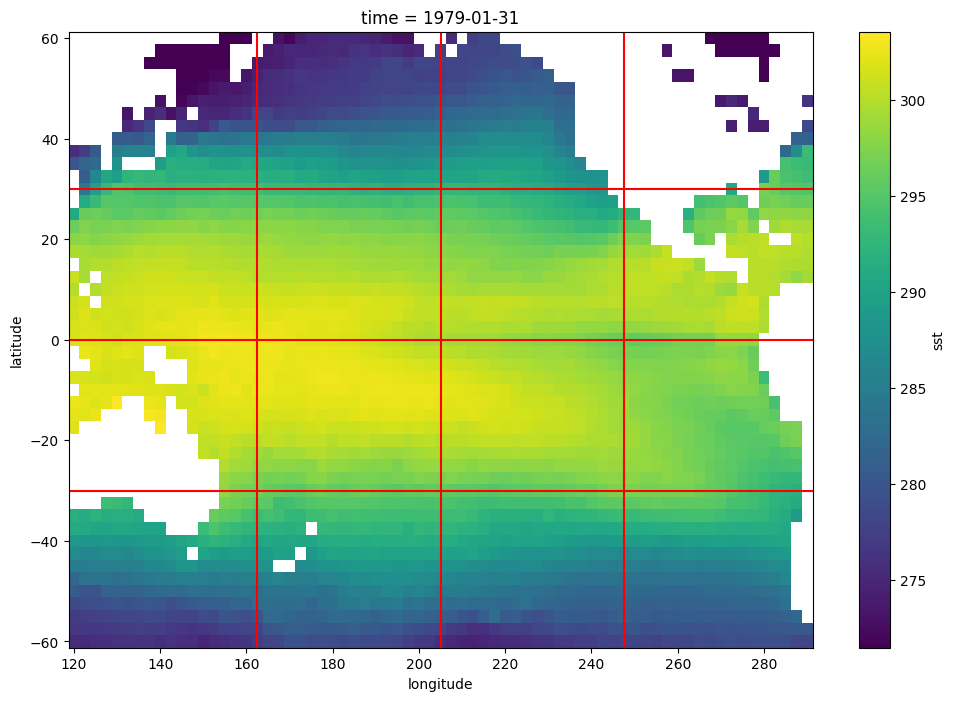

In [45]:
boxes1 = {
    0: [120,205,30,60],
    1: [205,290,30,60],
    2: [120,205,0,30],
    3: [205,290,0,30],
    4: [120,205,-30,0],
    5: [205,290,-30,0],
    6: [120,205,-60,-30],
    7: [205,290,-60,-30]
}
# New dictionary to hold 16 sub-boxes
boxes2 = {}

# Counter for keys in boxes2
new_key = 0

# Iteratively split each box into two
for key, (lon_min, lon_max, lat_min, lat_max) in boxes1.items():
    # Calculate the longitude midpoint
    lon_mid = (lon_min + lon_max) / 2
    
    # Define two new sub-boxes by splitting along the longitude midpoint
    boxes2[new_key] = [lon_min, lon_mid, lat_min, lat_max]
    new_key += 1
    boxes2[new_key] = [lon_mid, lon_max, lat_min, lat_max]
    new_key += 1

fig, axs = plt.subplots(figsize=(12,8))
ds_5means.sel(latitude=slice(-60,60), longitude=slice(120,290)).sst.isel(time=0).plot(ax=axs)
for i in range(3):
    axs.axhline(-30+i*30, c="red")
axs.axvline(205, c="red")
axs.axvline(162.5, c="red")
axs.axvline(247.5, c="red")
plt.show()

In [10]:
variables = ["SST", "SP", "TTR", "U10", "V10"]
var_combi = []

for r in range(1, len(variables) + 1):
    var_combi.extend(combinations(variables, r))

# Iterate over each box and each combination of variables
k = 0
pcas = {}
for box_id, box_coords in boxes2.items():
    for var_combination in var_combi:
        pcas[k] = MultivariatePCA(ds_5means, 3, [1980,2022], box_limit=box_coords, variables=var_combination)

        k +=1

for box_id, box_coords in boxes1.items():
    for var_combination in var_combi:
        pcas[k] = MultivariatePCA(ds_5means, 3, [1980,2022], box_limit=box_coords, variables=var_combination)
        
        k +=1

In [5]:
import pickle
with open("pcas.pkl", 'rb') as inp:
    pcas = pickle.load(inp)

In [7]:
hwis_chile= pd.read_csv(f"data/local_data/HWs_chile_central.csv")
hwis_chile["Date"] = pd.to_datetime(hwis_chile["Date"],format='%Y-%m-%d')
hwis_chile.set_index('Date', inplace=True)
hwis_chile = hwis_chile.rolling(2).mean()
hwis_cali= pd.read_csv(f"data/local_data/HWs_california.csv")
hwis_cali["Date"] = pd.to_datetime(hwis_cali["Date"],format='%Y-%m-%d')
hwis_cali.set_index('Date', inplace=True)
hwis_cali = hwis_cali.rolling(2).mean()


## Chile

In [8]:
hwis_chile = hwis_chile[(hwis_chile.index.year <= 2022) & (hwis_chile.index.year >= 2000)]

for mode in range(pcas[0].n_modes):
    for num, pca in pcas.items():
        hwis_chile[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=2000)

C:\Users\marti\AppData\Local\Temp\ipykernel_13512\2948219995.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hwis_chile[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=2000)
C:\Users\marti\AppData\Local\Temp\ipykernel_13512\2948219995.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hwis_chile[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=2000)
C:\Users\marti\AppData\Local\Temp\ipykernel_13512\2948219995.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

In [9]:
corr_chile = hwis_chile.corr()[["HWN", "HWF", "HWD", "HWM", "HWA"]][5:]
corr_chile

,HWN,HWF,HWD,HWM,HWA
PC_0-Mode-1,0.121422,0.136425,0.134680,0.137139,0.130307
PC_1-Mode-1,-0.088490,-0.102822,-0.094965,-0.054153,-0.062470
PC_2-Mode-1,-0.096171,-0.104602,-0.086510,-0.104722,-0.103001
PC_3-Mode-1,0.030380,0.023854,0.037358,0.035797,0.035503
PC_4-Mode-1,-0.015753,-0.010663,-0.022086,-0.023010,-0.024497
...,...,...,...,...,...
PC_739-Mode-3,0.085531,0.091478,0.052245,0.087843,0.094197
PC_740-Mode-3,-0.144511,-0.141965,-0.108338,-0.084335,-0.123250
PC_741-Mode-3,-0.062425,-0.052069,-0.022187,-0.080146,-0.085895
PC_742-Mode-3,-0.134494,-0.119945,-0.095199,-0.112994,-0.128300


In [10]:
indices_of_interest = ["HWN", "HWF", "HWD", "HWM", "HWA"]

season_correlations_chile = {}

for i in range(12):
    hwis_month = hwis_chile[hwis_chile.index.month == i+1]
    correlations = {
    "pearson": compute_correlations(hwis_month),
    "spearman": compute_correlations(hwis_month, method='spearman')
    }

    # Initialize dictionaries to hold positive and negative correlations
    strong_correlations = {
        "positive": {"pearson": [], "spearman": []},
        "negative": {"pearson": [], "spearman": []}
    }

    # Iterate over each correlation matrix and collect pairs
    for method, corr_df in correlations.items():
        for timeserie, row in corr_df.iterrows():
            for index, value in row.items():
                if value > 0.5:
                    strong_correlations["positive"][method].append((timeserie, index, value))
                elif value < -0.5:
                    strong_correlations["negative"][method].append((timeserie, index, value))

    # Convert to DataFrames for easy viewing and saving
    positive_corr_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in strong_correlations["positive"].items()
    }
    negative_corr_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in strong_correlations["negative"].items()
    }
    season_correlations_chile[i+1] = [positive_corr_df, negative_corr_df]
    print("Ready season", i+1)



Ready season 1
Ready season 2
Ready season 3
Ready season 4
Ready season 5
Ready season 6
Ready season 7
Ready season 8
Ready season 9
Ready season 10
Ready season 11
Ready season 12


In [ ]:
# Initialize a list to collect all correlations from all months and methods
all_correlations = []

# Iterate through each month in the season_correlations_chile dictionary
for month, (positive_corr_dict, negative_corr_dict) in season_correlations_chile.items():
    # Combine positive and negative correlations for each method
    for method in ["pearson", "spearman"]:
        if method in positive_corr_dict:
            for _, row in positive_corr_dict[method].iterrows():
                all_correlations.append((month, method, *row))
        
        if method in negative_corr_dict:
            for _, row in negative_corr_dict[method].iterrows():
                all_correlations.append((month, method, *row))

# Convert the collected data to a DataFrame for easier processing
all_correlations_df = pd.DataFrame(
    all_correlations, columns=["Season", "Method", "PC", "Index", "Correlation"]
)
all_correlations_df['ID'] = all_correlations_df['PC'].apply(lambda x: re.search(r'PC_(.*?)-Mode-', x).group(1))
# Sort by the absolute value of the correlation and get the top 10
top_correlations = all_correlations_df.reindex(
    all_correlations_df["Correlation"].abs().sort_values(ascending=False).index
).head(30)

# Display the top 10 correlations
print(top_correlations)

      Season    Method             PC Index  Correlation
4685       5  spearman  PC_347-Mode-2   HWN    -0.912782
3139       4   pearson  PC_463-Mode-3   HWA    -0.896517
2827       4   pearson  PC_464-Mode-3   HWA     0.894508
3898       4  spearman  PC_455-Mode-3   HWA    -0.882449
8820      12   pearson  PC_683-Mode-3   HWN     0.875649
3104       4   pearson  PC_439-Mode-3   HWD    -0.875111
3138       4   pearson  PC_463-Mode-3   HWM    -0.872847
2826       4   pearson  PC_464-Mode-3   HWM     0.871804
8823      12   pearson  PC_683-Mode-3   HWM     0.866669
4697       5  spearman  PC_356-Mode-2   HWN    -0.865946
3103       4   pearson  PC_439-Mode-3   HWF    -0.864892
2817       4   pearson  PC_457-Mode-3   HWA     0.863952
3897       4  spearman  PC_455-Mode-3   HWM    -0.862816
4571       5  spearman  PC_473-Mode-3   HWF     0.861816
4379       5  spearman  PC_341-Mode-2   HWF     0.860781
3102       4   pearson  PC_439-Mode-3   HWN    -0.852991
780        1  spearman  PC_101-

In [12]:
print(f"PC_347 is on Box {pcas[347].box} with variables {list(pcas[347].variables_dict.values())}")

PC_347 is on Box [247.5, 290, -30, 0] with variables ['SST', 'TTR']


### Appearances

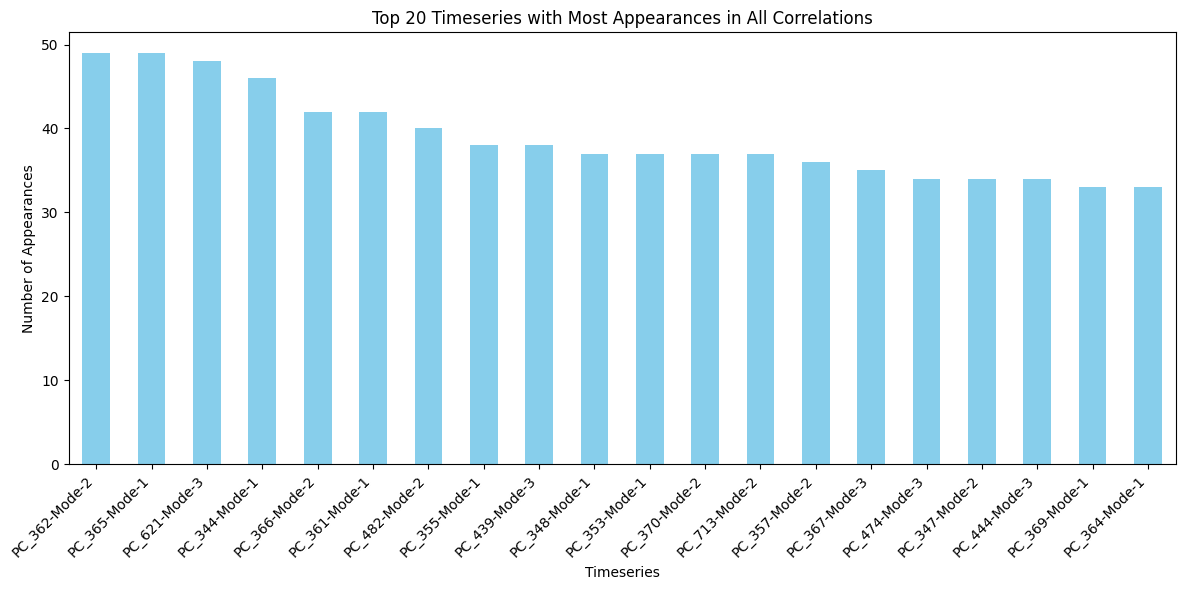

In [13]:
timeseries_count = all_correlations_df['PC'].value_counts()

# Get the top 20 most frequent timeseries
top_20_timeseries = timeseries_count.head(20)

plt.figure(figsize=(12, 6))
top_20_timeseries.plot(kind='bar', color='skyblue')
plt.title('Top 20 Timeseries with Most Appearances in All Correlations')
plt.xlabel('Timeseries')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

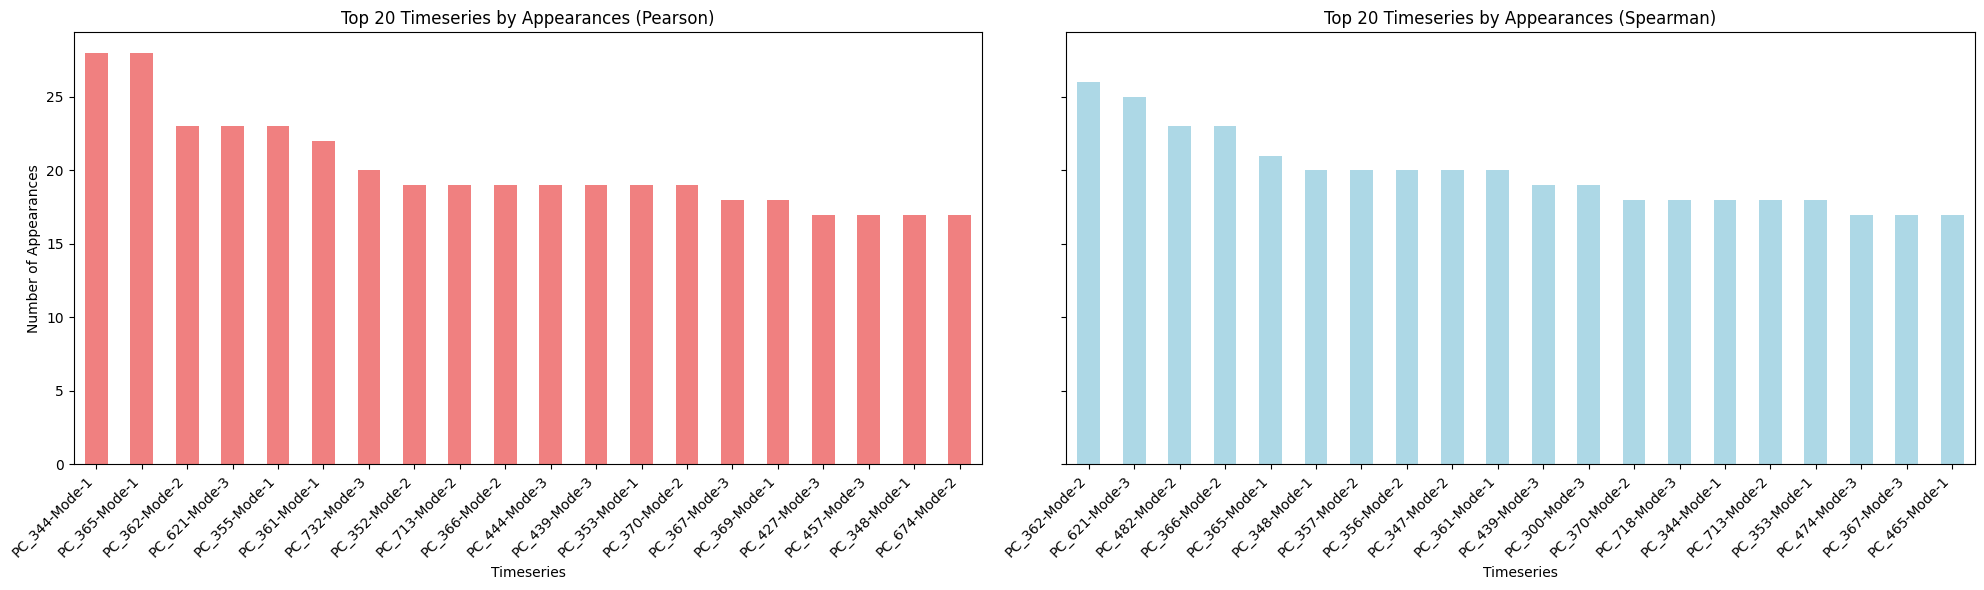

In [14]:
# Filter and count appearances for each method
methods = ["pearson", "spearman"]
method_counts = {}

for method in methods:
    # Filter the DataFrame for the current method
    method_df = all_correlations_df[all_correlations_df['Method'] == method]
    # Count the frequency of each timeseries in the 'Timeserie' column
    method_counts[method] = method_df['PC'].value_counts()

# Get the top 20 timeseries for each method
top_20_counts = {
    method: counts.head(20) for method, counts in method_counts.items()
}

# Plot the top 20 timeseries for each method
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

for i, method in enumerate(methods):
    ax = axes[i]
    top_20_counts[method].plot(kind='bar', color='lightcoral' if method == "pearson" else 'lightblue', ax=ax)
    ax.set_title(f'Top 20 Timeseries by Appearances ({method.capitalize()})')
    ax.set_xlabel('Timeseries')
    ax.set_ylabel('Number of Appearances')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

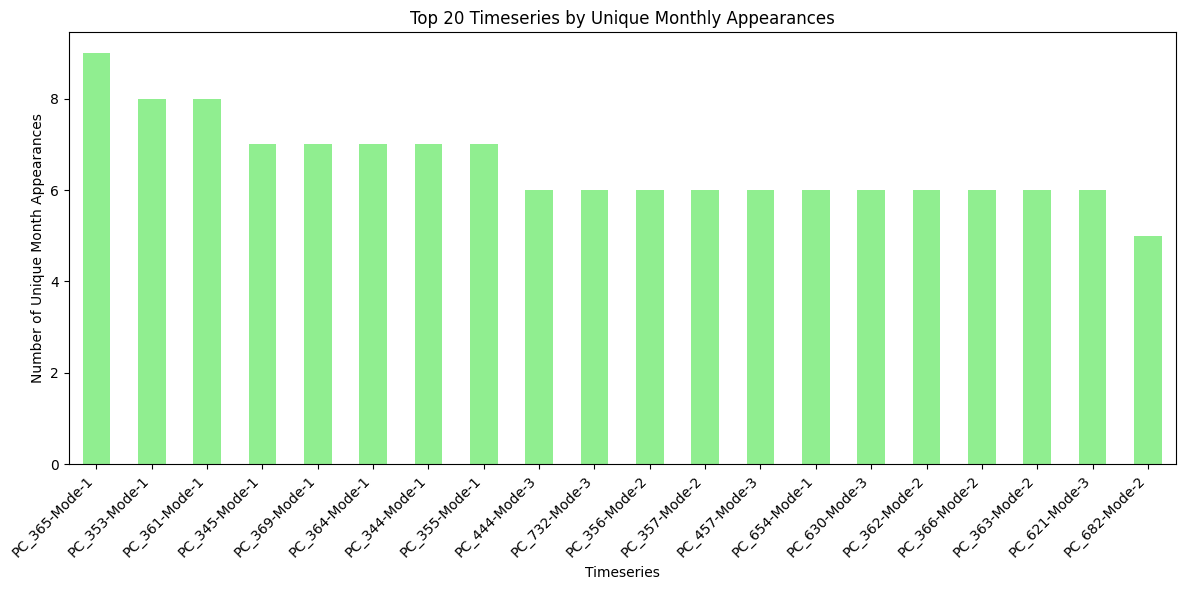

In [15]:
# Create a DataFrame to store unique appearances by month
unique_monthly_counts = all_correlations_df.groupby(['Season', 'PC']).size().reset_index(name='Count')

# Remove duplicate timeseries per month by setting 'Count' to 1 where it exists
unique_monthly_counts['Count'] = 1

# Count how many times each timeseries appears across all months (unique per month)
total_unique_counts = unique_monthly_counts.groupby('PC')['Count'].sum()

# Get the top 20 timeseries by the number of unique month appearances
top_20_unique_timeseries = total_unique_counts.sort_values(ascending=False).head(20)

# Plot the top 20 timeseries in a bar plot
plt.figure(figsize=(12, 6))
top_20_unique_timeseries.plot(kind='bar', color='lightgreen')
plt.title('Top 20 Timeseries by Unique Monthly Appearances')
plt.xlabel('Timeseries')
plt.ylabel('Number of Unique Month Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

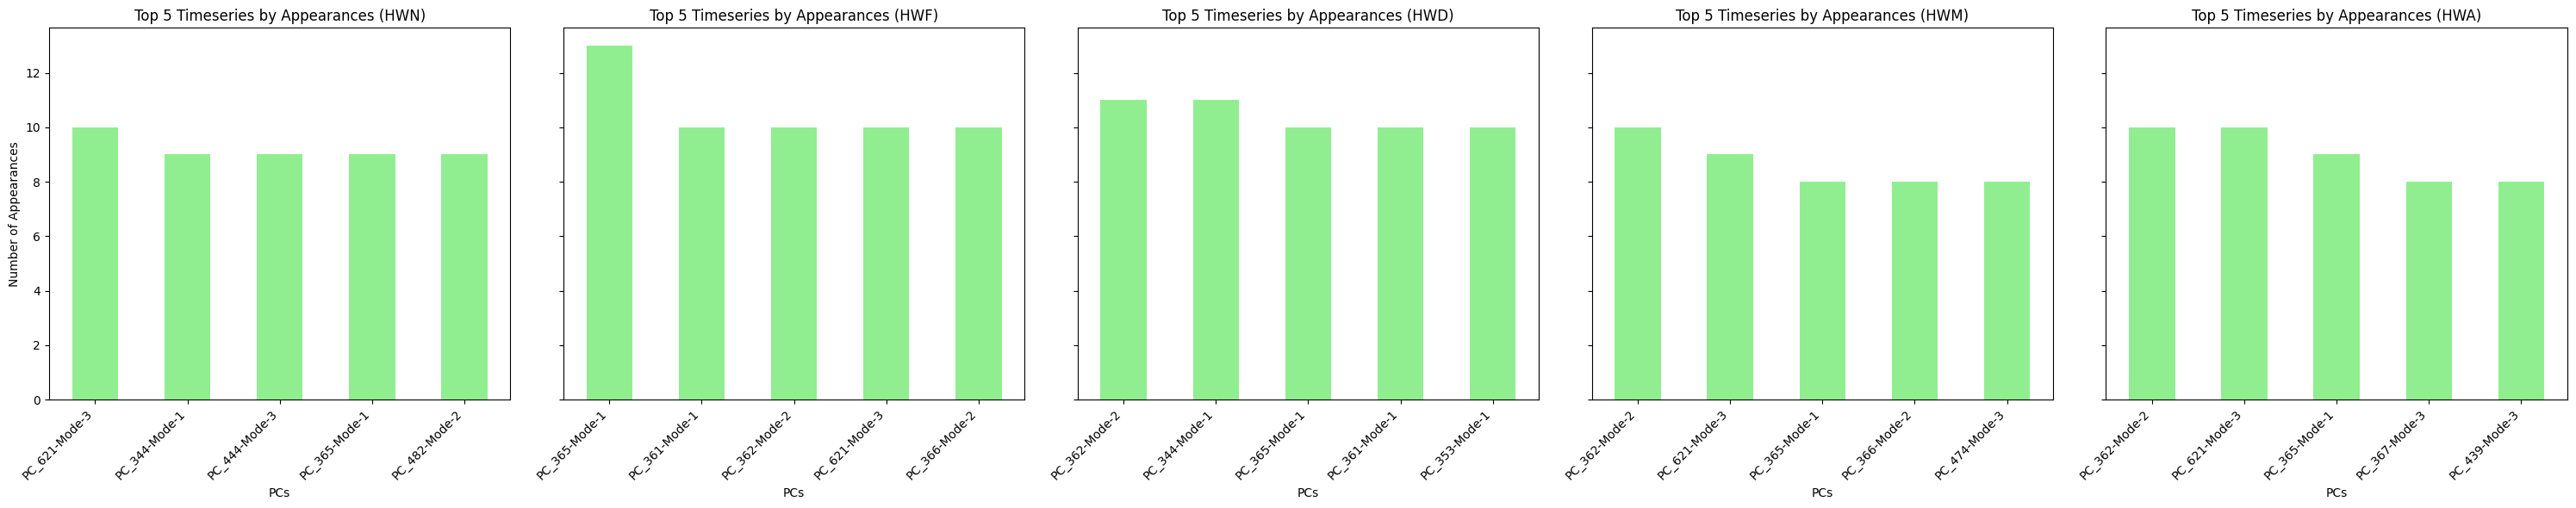

In [16]:
# Initialize a dictionary to store counts for each index
index_counts = {}

# Iterate over each index and count appearances
for index in indices_of_interest:
    # Filter the DataFrame for the current index
    index_df = all_correlations_df[all_correlations_df['Index'] == index]
    # Count the frequency of each timeseries in the 'Timeserie' column
    index_counts[index] = index_df['PC'].value_counts()

# Get the top 20 timeseries for each index
top_20_index_counts = {
    index: counts.head(5) for index, counts in index_counts.items()
}

# Plot the top 20 timeseries for each index
fig, axes = plt.subplots(1, 5, figsize=(30, 6), sharey=True)

for i, index in enumerate(indices_of_interest):
    ax = axes[i]
    if index in top_20_index_counts:
        top_20_index_counts[index].plot(kind='bar', color='lightgreen', ax=ax)
        ax.set_title(f'Top 5 Timeseries by Appearances ({index})')
        ax.set_xlabel('PCs')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Number of Appearances')

plt.tight_layout()
plt.show()


### Average

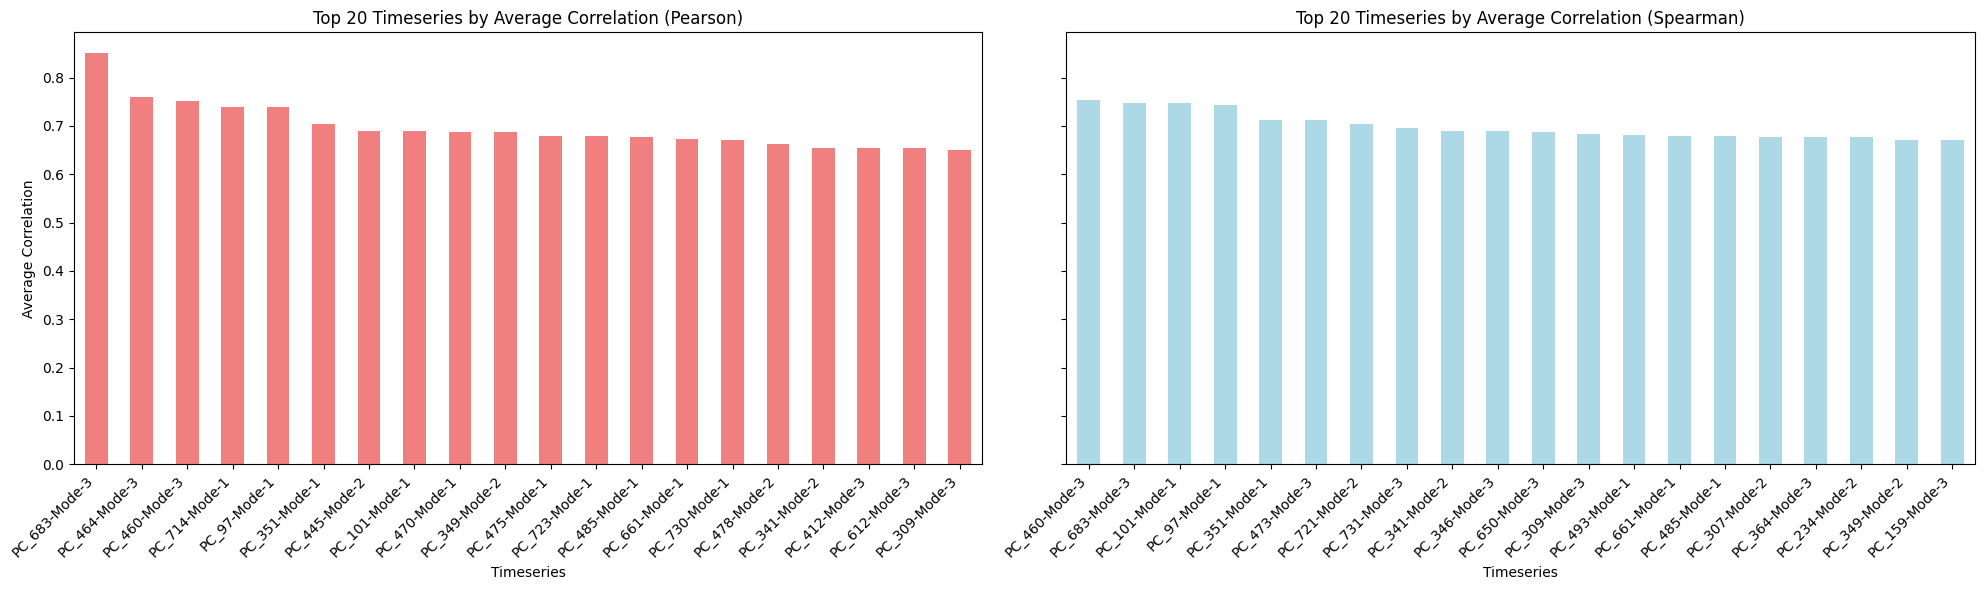

In [17]:
# Initialize a dictionary to store average correlations for each method
methods = ["pearson", "spearman"]
method_avg_correlation = {}

for method in methods:
    # Filter the DataFrame for the current method
    method_df = all_correlations_df[all_correlations_df['Method'] == method]
    # Calculate the average correlation for each timeseries
    method_avg_correlation[method] = method_df.groupby('PC')['Correlation'].mean().sort_values(ascending=False)

# Get the top 20 timeseries by average correlation for each method
top_20_avg_correlation = {
    method: correlations.head(20) for method, correlations in method_avg_correlation.items()
}

# Plot the top 20 timeseries by average correlation for each method
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

for i, method in enumerate(methods):
    ax = axes[i]
    top_20_avg_correlation[method].plot(kind='bar', color='lightcoral' if method == "pearson" else 'lightblue', ax=ax)
    ax.set_title(f'Top 20 Timeseries by Average Correlation ({method.capitalize()})')
    ax.set_xlabel('Timeseries')
    ax.set_ylabel('Average Correlation')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

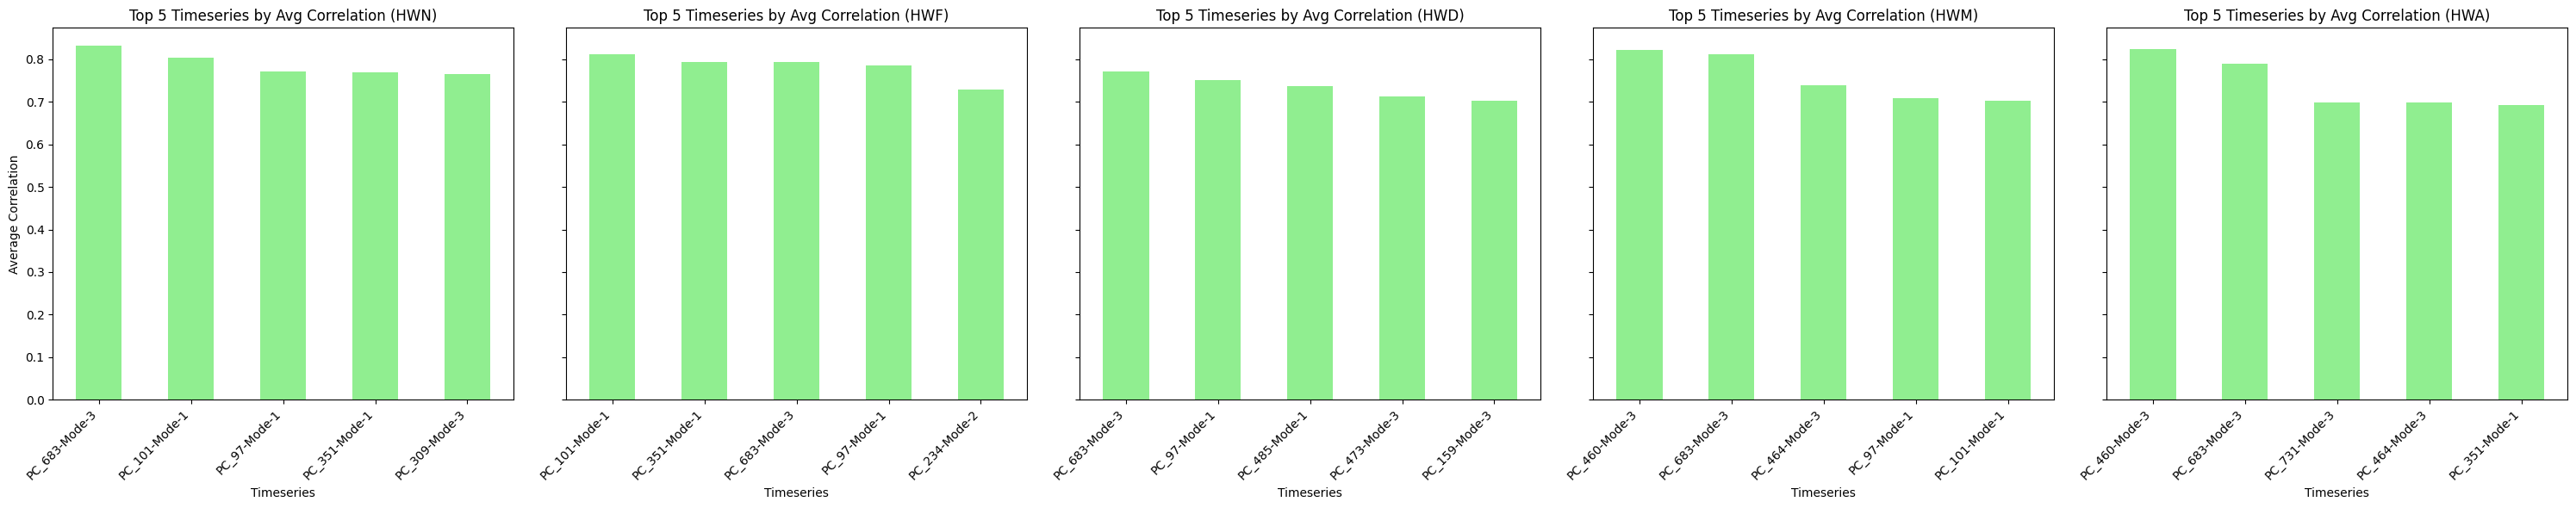

In [18]:
index_avg_correlation = {}

# Iterate over each index and compute average correlation
for index in indices_of_interest:
    # Filter the DataFrame for the current index
    index_df = all_correlations_df[all_correlations_df['Index'] == index]
    # Calculate the average correlation for each timeseries
    index_avg_correlation[index] = index_df.groupby('PC')['Correlation'].mean().sort_values(ascending=False)

# Get the top 20 timeseries by average correlation for each index
top_20_index_avg_correlation = {
    index: correlations.head(5) for index, correlations in index_avg_correlation.items()
}

# Plot the top 20 timeseries by average correlation for each index
fig, axes = plt.subplots(1, 5, figsize=(30, 6), sharey=True)

for i, index in enumerate(indices_of_interest):
    ax = axes[i]
    if index in top_20_index_avg_correlation:
        top_20_index_avg_correlation[index].plot(kind='bar', color='lightgreen', ax=ax)
        ax.set_title(f'Top 5 Timeseries by Avg Correlation ({index})')
        ax.set_xlabel('Timeseries')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Average Correlation')

plt.tight_layout()
plt.show()

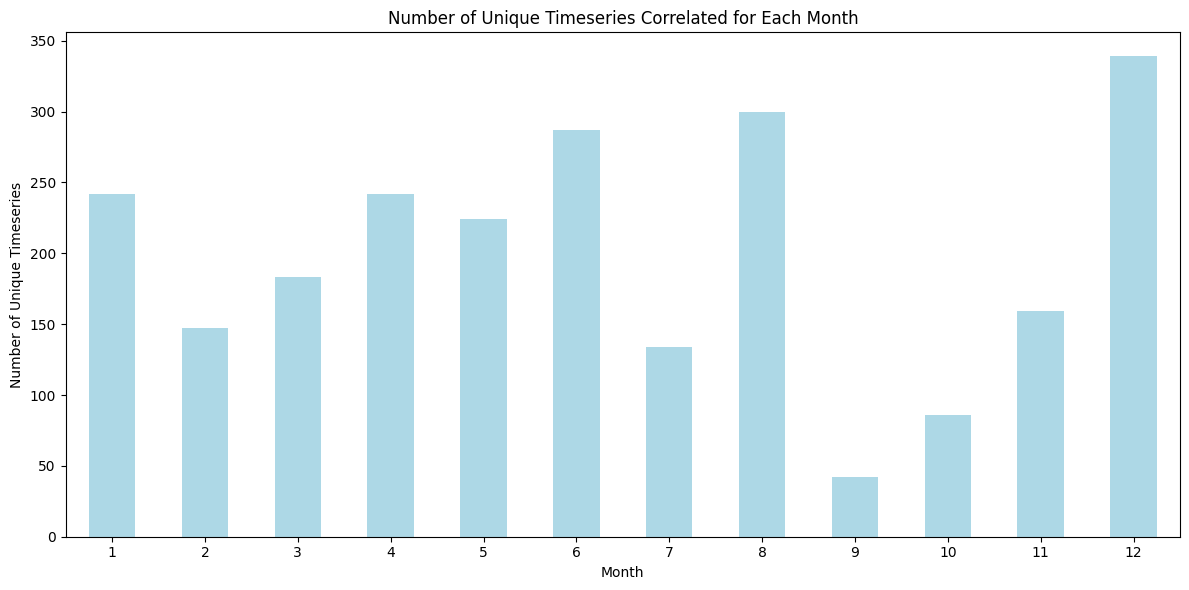

In [36]:
# Create a DataFrame to count unique timeseries appearances per month
unique_month_counts = all_correlations_df.groupby(['Season', 'PC']).size().reset_index(name='Count')

# Set 'Count' to 1 to represent a unique appearance per timeseries per month
unique_month_counts['Count'] = 1

# Sum the number of unique timeseries for each month
timeseries_per_month = unique_month_counts.groupby('Season')['Count'].sum()

# Plot the number of timeseries that appear correlated for each month
plt.figure(figsize=(12, 6))
timeseries_per_month.plot(kind='bar', color='lightblue')
plt.title('Number of Unique Timeseries Correlated for Each Month')
plt.xlabel('Month')
plt.ylabel('Number of Unique Timeseries')
plt.xticks(rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

As shown, there are a lot of potential predictors for each biseason excluding season 9 (August-September). Note that total predictors in this case is 744x3 = 2232. Remember each appearance is counted if a PC-mode combination correlates with any of the 5 HW indices.

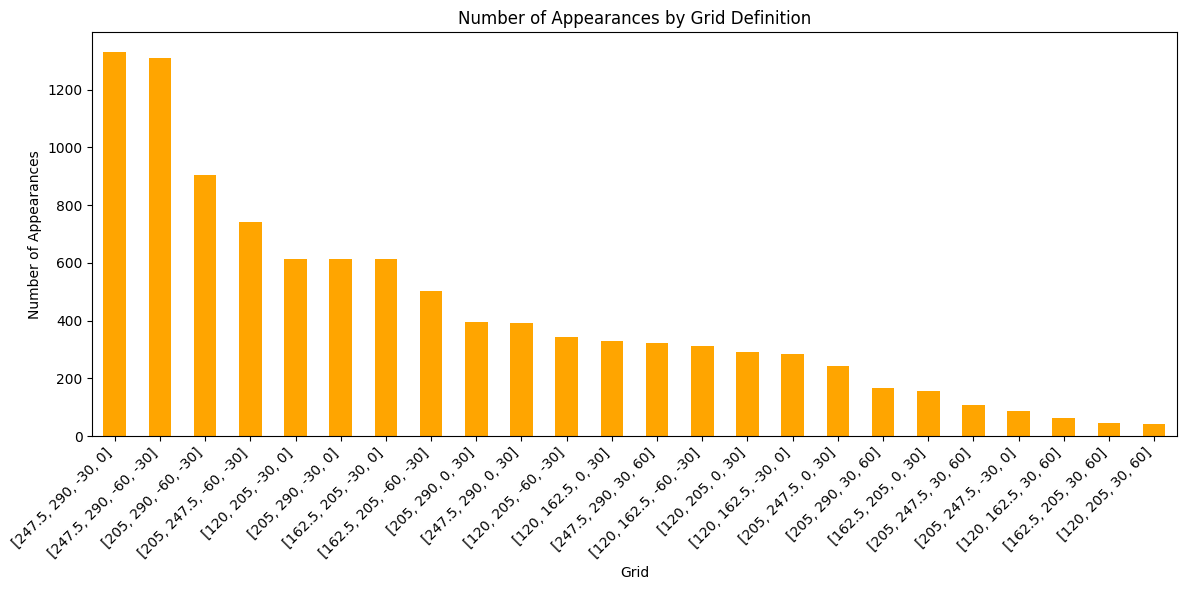

In [41]:

# Extract the 'grid' information for each timeseries ID in `all_correlations_df`
all_correlations_df['Grid'] = all_correlations_df['ID'].map(lambda ts_id: pcas[int(ts_id)].box)

# Count the number of times each grid appears in the correlations DataFrame
grid_counts = all_correlations_df['Grid'].value_counts()

# Plot the counts of appearances for each grid
plt.figure(figsize=(12, 6))
grid_counts.plot(kind='bar', color='orange')
plt.title('Number of Appearances by Grid Definition')
plt.xlabel('Grid')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

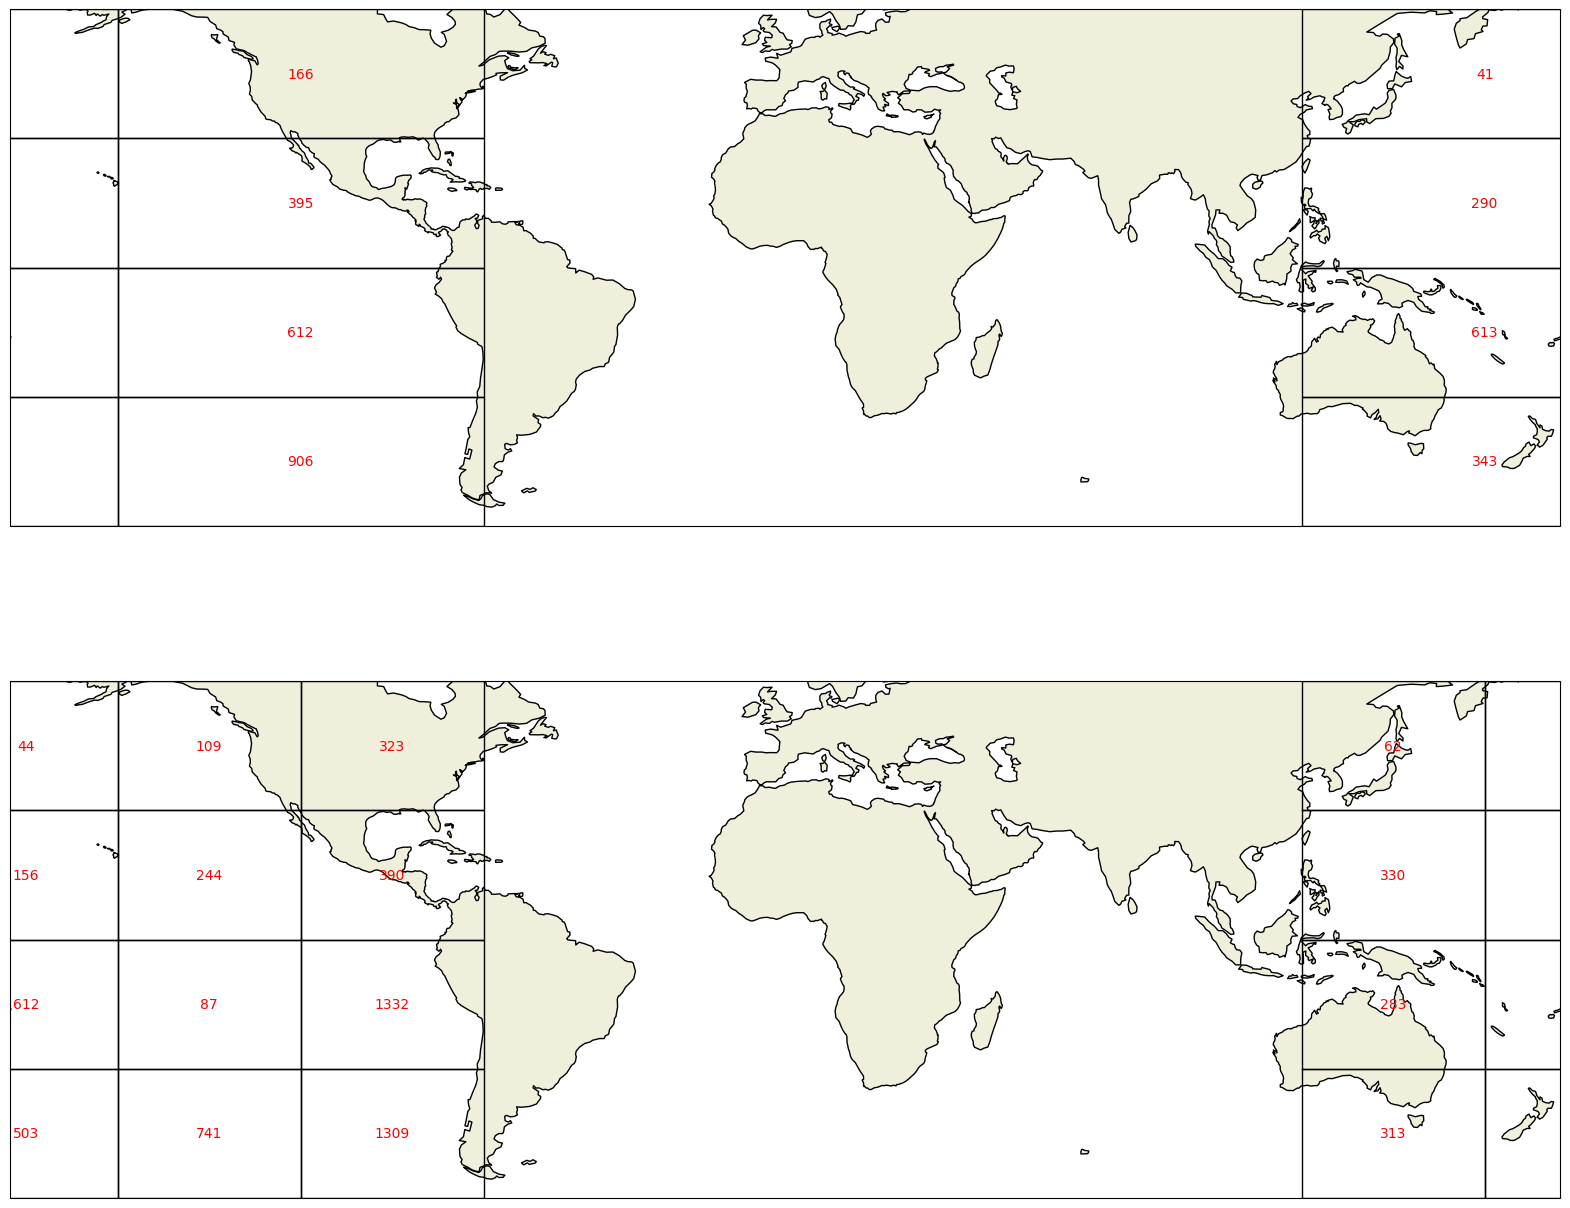

In [105]:
# Create a figure and axis
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())

# Set map extent
ax.set_extent([120, 290, -60, 60], crs=ccrs.PlateCarree())

# Add land and coastlines
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

# Plot the boxes and their counts
for grid, count in grid_counts.items():
    if grid in boxes1.values():
        min_lon, max_lon, min_lat, max_lat = grid
        
        ax.plot([min_lon, max_lon, max_lon, min_lon, min_lon],
                [min_lat, min_lat, max_lat, max_lat, min_lat],
                color='black', linewidth=1, transform=ccrs.PlateCarree())
        ax.text((min_lon + max_lon) / 2, (min_lat + max_lat) / 2,
                str(count),
                horizontalalignment='center',
                verticalalignment='center',
                transform=ccrs.PlateCarree(), color="r")
        

ax2.set_extent([120, 290, -60, 60], crs=ccrs.PlateCarree())

# Add land and coastlines
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.COASTLINE)

# Plot the boxes and their counts
for grid, count in grid_counts.items():
    if grid in boxes2.values():
        min_lon, max_lon, min_lat, max_lat = grid
        
        ax2.plot([min_lon, max_lon, max_lon, min_lon, min_lon],
                [min_lat, min_lat, max_lat, max_lat, min_lat],
                color='black', linewidth=1, transform=ccrs.PlateCarree())
        ax2.text((min_lon + max_lon) / 2, (min_lat + max_lat) / 2,
                str(count),
                horizontalalignment='center',
                verticalalignment='center',
                transform=ccrs.PlateCarree(), color="r")

plt.show()

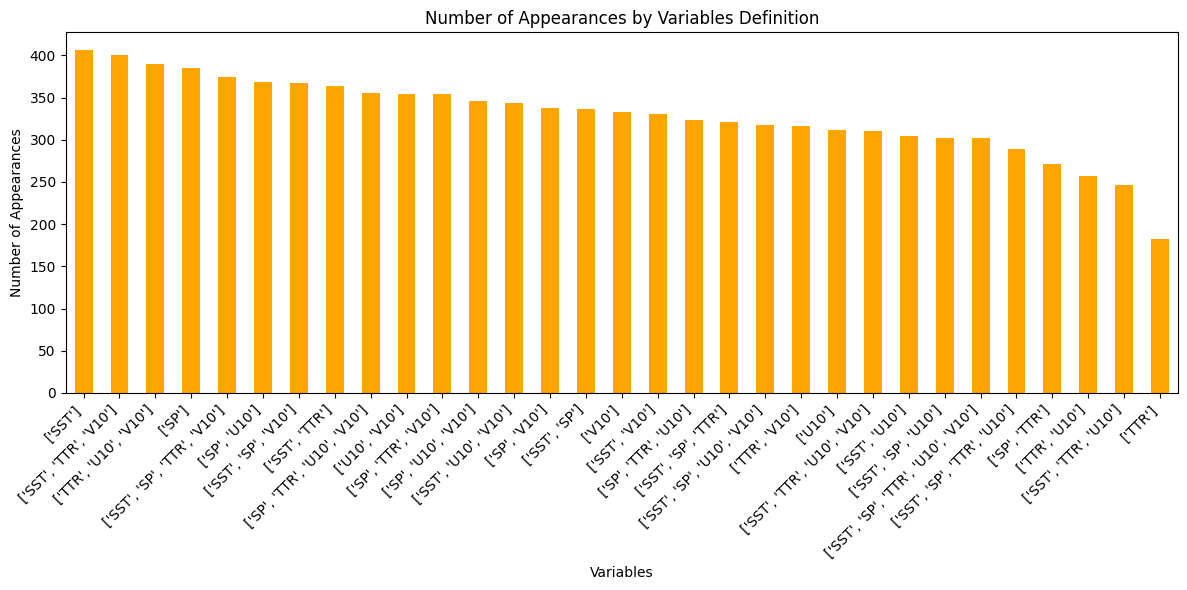

In [120]:

# Extract the 'grid' information for each timeseries ID in `all_correlations_df`
all_correlations_df['Variables'] = all_correlations_df['ID'].map(lambda ts_id: str(list(pcas[int(ts_id)].variables_dict.values())))

# Count the number of times each grid appears in the correlations DataFrame
variables = all_correlations_df['Variables'].value_counts()

# Plot the counts of appearances for each grid
plt.figure(figsize=(12, 6))
variables.plot(kind='bar', color='orange')
plt.title('Number of Appearances by Variables Definition')
plt.xlabel('Variables')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

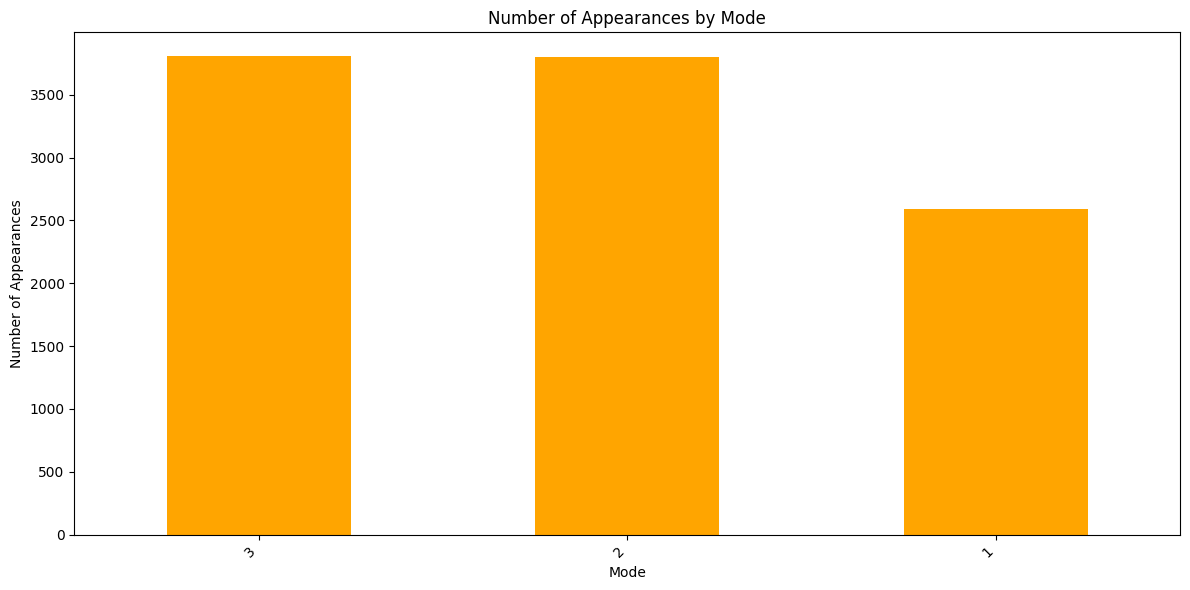

In [122]:

# Extract the 'grid' information for each timeseries ID in `all_correlations_df`
all_correlations_df['Mode'] = all_correlations_df['PC'].map(lambda pc_str: int(pc_str[-1]))

# Count the number of times each grid appears in the correlations DataFrame
modes = all_correlations_df['Mode'].value_counts()

# Plot the counts of appearances for each grid
plt.figure(figsize=(12, 6))
modes.plot(kind='bar', color='orange')
plt.title('Number of Appearances by Mode')
plt.xlabel('Mode')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

## California

In [123]:
hwis_cali = hwis_cali[(hwis_cali.index.year <= 2022) & (hwis_cali.index.year >= 2000)]

for mode in range(pcas[0].n_modes):
    for num, pca in pcas.items():
        hwis_cali[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=2000)

C:\Users\marti\AppData\Local\Temp\ipykernel_13512\2402938494.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hwis_cali[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=2000)
C:\Users\marti\AppData\Local\Temp\ipykernel_13512\2402938494.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hwis_cali[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=2000)
C:\Users\marti\AppData\Local\Temp\ipykernel_13512\2402938494.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [124]:
season_correlations_cali = {}

for i in range(12):
    hwis_month = hwis_cali[hwis_cali.index.month == i+1]
    correlations = {
    "pearson": compute_correlations(hwis_month, method='pearson'),
    "spearman": compute_correlations(hwis_month, method='spearman')
}

    # Initialize dictionaries to hold positive and negative correlations
    strong_correlations = {
        "positive": {"pearson": [], "spearman": []},
        "negative": {"pearson": [], "spearman": []}
    }

    # Iterate over each correlation matrix and collect pairs
    for method, corr_df in correlations.items():
        for timeserie, row in corr_df.iterrows():
            for index, value in row.items():
                if value > 0.5:
                    strong_correlations["positive"][method].append((timeserie, index, value))
                elif value < -0.5:
                    strong_correlations["negative"][method].append((timeserie, index, value))

    # Convert to DataFrames for easy viewing and saving
    positive_corr_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in strong_correlations["positive"].items()
    }
    negative_corr_df = {
        method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
        for method, pairs in strong_correlations["negative"].items()
    }
    season_correlations_cali[i+1] = [positive_corr_df, negative_corr_df]
    print("Ready season", i+1)


Ready season 1
Ready season 2
Ready season 3
Ready season 4
Ready season 5
Ready season 6
Ready season 7
Ready season 8
Ready season 9
Ready season 10
Ready season 11
Ready season 12


In [125]:
# Initialize a list to collect all correlations from all months and methods
all_correlations = []

# Iterate through each month in the season_correlations_chile dictionary
for month, (positive_corr_dict, negative_corr_dict) in season_correlations_cali.items():
    # Combine positive and negative correlations for each method
    for method in ["pearson", "spearman"]:
        if method in positive_corr_dict:
            for _, row in positive_corr_dict[method].iterrows():
                all_correlations.append((month, method, *row))
        
        if method in negative_corr_dict:
            for _, row in negative_corr_dict[method].iterrows():
                all_correlations.append((month, method, *row))

# Convert the collected data to a DataFrame for easier processing
all_correlations_df = pd.DataFrame(
    all_correlations, columns=["Season", "Method", "PC", "Index", "Correlation"]
)
all_correlations_df['ID'] = all_correlations_df['PC'].apply(lambda x: re.search(r'PC_(.*?)-Mode-', x).group(1))
top_correlations = all_correlations_df.reindex(
    all_correlations_df["Correlation"].abs().sort_values(ascending=False).index
).head(30)

print(top_correlations)

       Season    Method             PC Index  Correlation   ID
7002        7  spearman  PC_371-Mode-2   HWD    -0.842676  371
5911        7   pearson  PC_368-Mode-2   HWD     0.841222  368
5910        7   pearson  PC_368-Mode-2   HWF     0.837757  368
7001        7  spearman  PC_371-Mode-2   HWF    -0.836261  371
6652        7  spearman  PC_214-Mode-2   HWN     0.836158  214
6698        7  spearman  PC_368-Mode-2   HWD     0.833364  368
6656        7  spearman  PC_214-Mode-2   HWA     0.831400  214
3223        4   pearson  PC_241-Mode-2   HWF    -0.830846  241
6655        7  spearman  PC_214-Mode-2   HWM     0.828298  214
5915        7   pearson  PC_370-Mode-2   HWF     0.821549  370
5902        7   pearson  PC_364-Mode-2   HWD     0.820988  364
5901        7   pearson  PC_364-Mode-2   HWF     0.820379  364
6697        7  spearman  PC_368-Mode-2   HWF     0.820229  368
5916        7   pearson  PC_370-Mode-2   HWD     0.819884  370
1504        2   pearson  PC_547-Mode-2   HWA    -0.8180

In [126]:
print(f"PC_371 is on Box {pcas[371].box} with variables {list(pcas[371].variables_dict.values())}")

PC_371 is on Box [247.5, 290, -30, 0] with variables ['SST', 'SP', 'TTR', 'U10', 'V10']


### Appearances

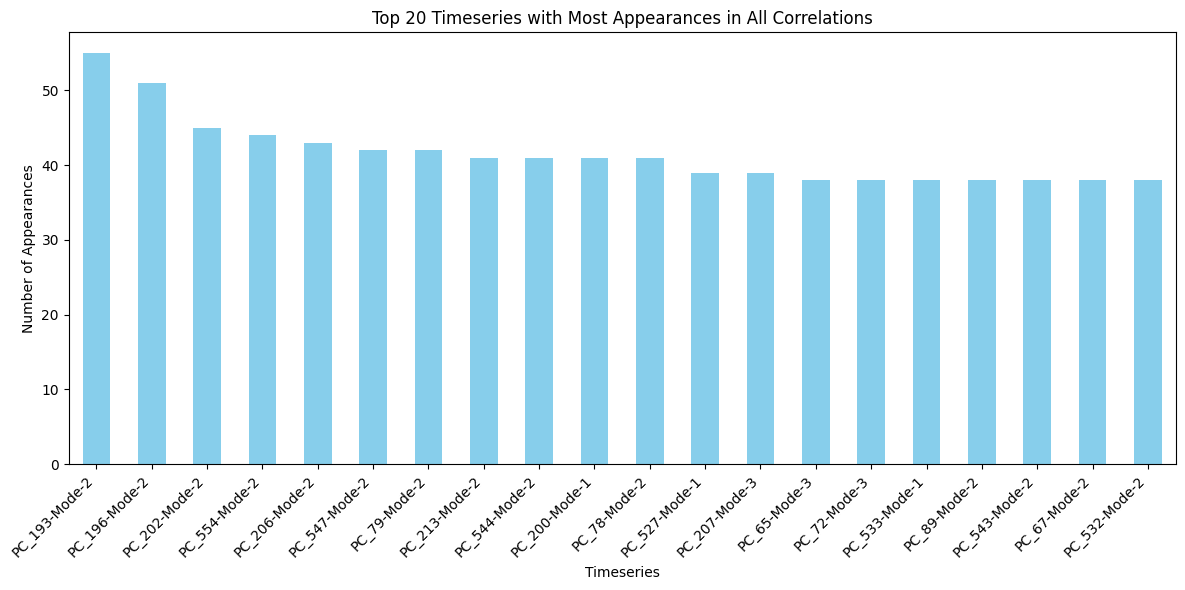

In [213]:
timeseries_count = all_correlations_df['PC'].value_counts()

# Get the top 20 most frequent timeseries
top_20_timeseries = timeseries_count.head(20)

plt.figure(figsize=(12, 6))
top_20_timeseries.plot(kind='bar', color='skyblue')
plt.title('Top 20 Timeseries with Most Appearances in All Correlations')
plt.xlabel('Timeseries')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

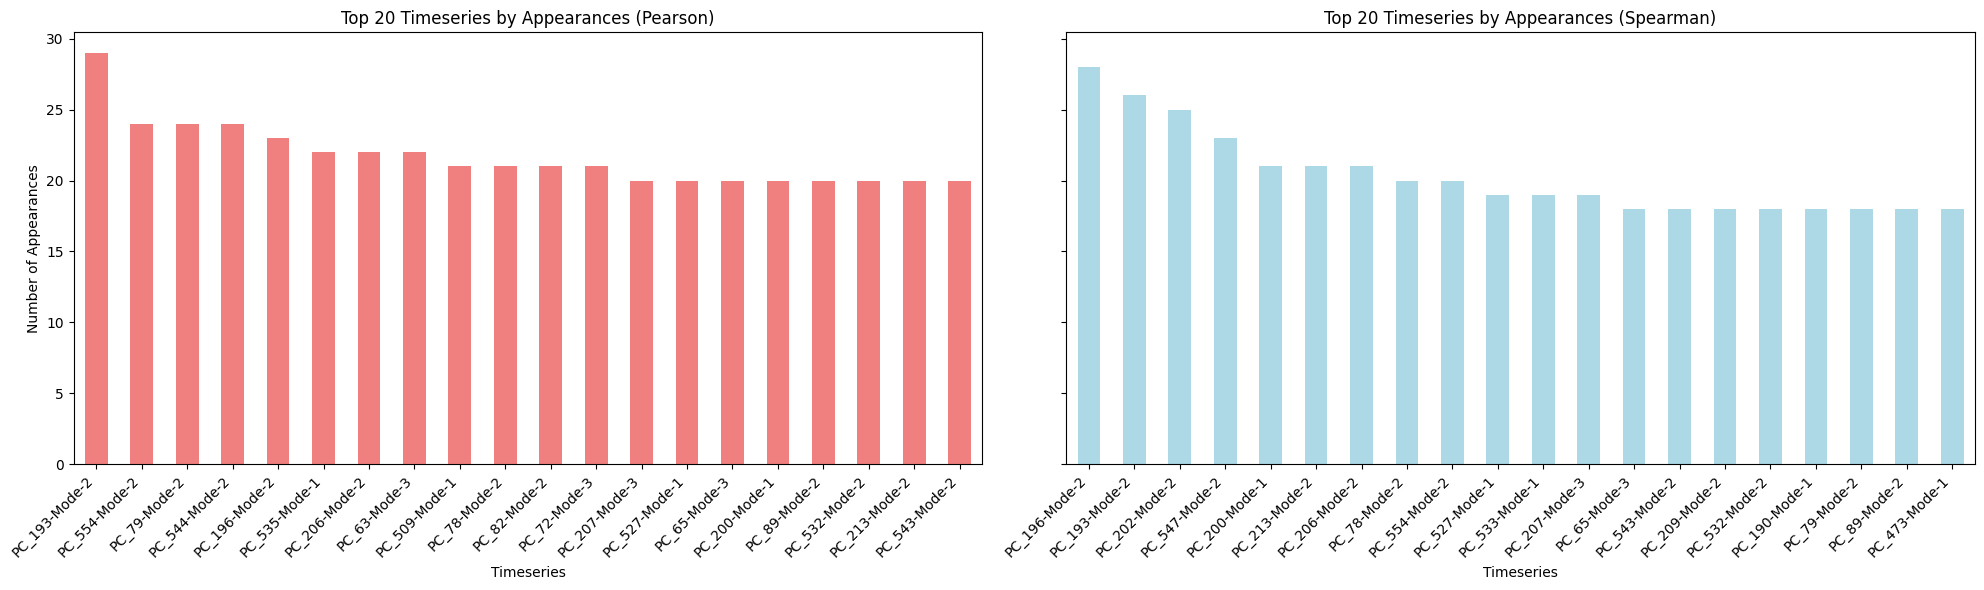

In [214]:
# Filter and count appearances for each method
methods = ["pearson", "spearman"]
method_counts = {}

for method in methods:
    # Filter the DataFrame for the current method
    method_df = all_correlations_df[all_correlations_df['Method'] == method]
    # Count the frequency of each timeseries in the 'Timeserie' column
    method_counts[method] = method_df['PC'].value_counts()

# Get the top 20 timeseries for each method
top_20_counts = {
    method: counts.head(20) for method, counts in method_counts.items()
}

# Plot the top 20 timeseries for each method
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

for i, method in enumerate(methods):
    ax = axes[i]
    top_20_counts[method].plot(kind='bar', color='lightcoral' if method == "pearson" else 'lightblue', ax=ax)
    ax.set_title(f'Top 20 Timeseries by Appearances ({method.capitalize()})')
    ax.set_xlabel('Timeseries')
    ax.set_ylabel('Number of Appearances')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

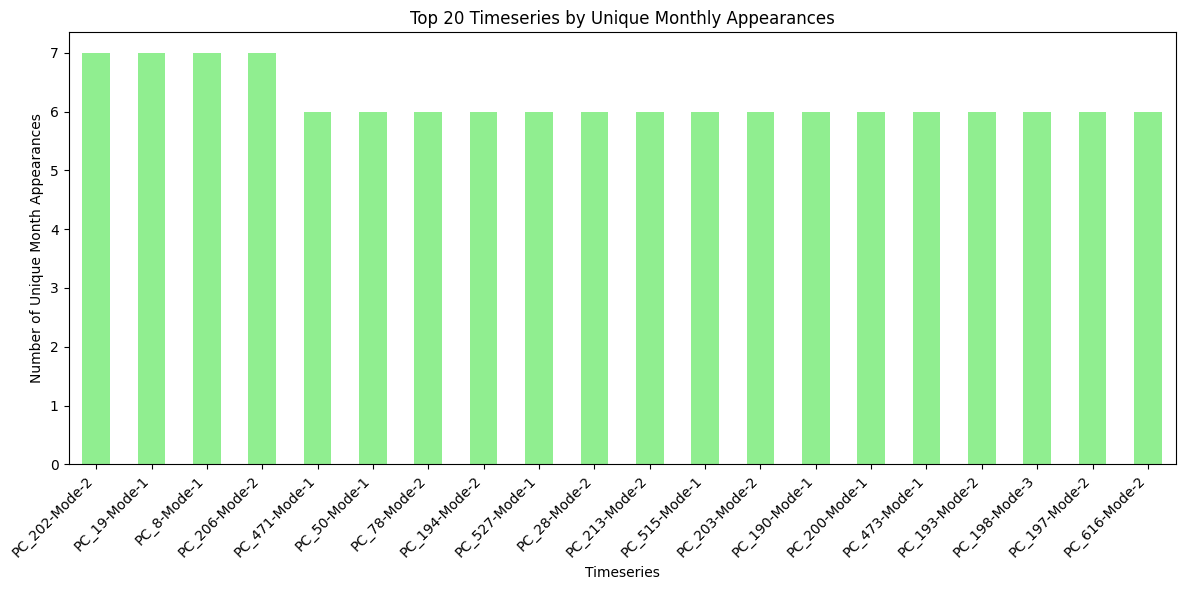

In [215]:
# Create a DataFrame to store unique appearances by month
unique_monthly_counts = all_correlations_df.groupby(['Season', 'PC']).size().reset_index(name='Count')

# Remove duplicate timeseries per month by setting 'Count' to 1 where it exists
unique_monthly_counts['Count'] = 1

# Count how many times each timeseries appears across all months (unique per month)
total_unique_counts = unique_monthly_counts.groupby('PC')['Count'].sum()

# Get the top 20 timeseries by the number of unique month appearances
top_20_unique_timeseries = total_unique_counts.sort_values(ascending=False).head(20)

# Plot the top 20 timeseries in a bar plot
plt.figure(figsize=(12, 6))
top_20_unique_timeseries.plot(kind='bar', color='lightgreen')
plt.title('Top 20 Timeseries by Unique Monthly Appearances')
plt.xlabel('Timeseries')
plt.ylabel('Number of Unique Month Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

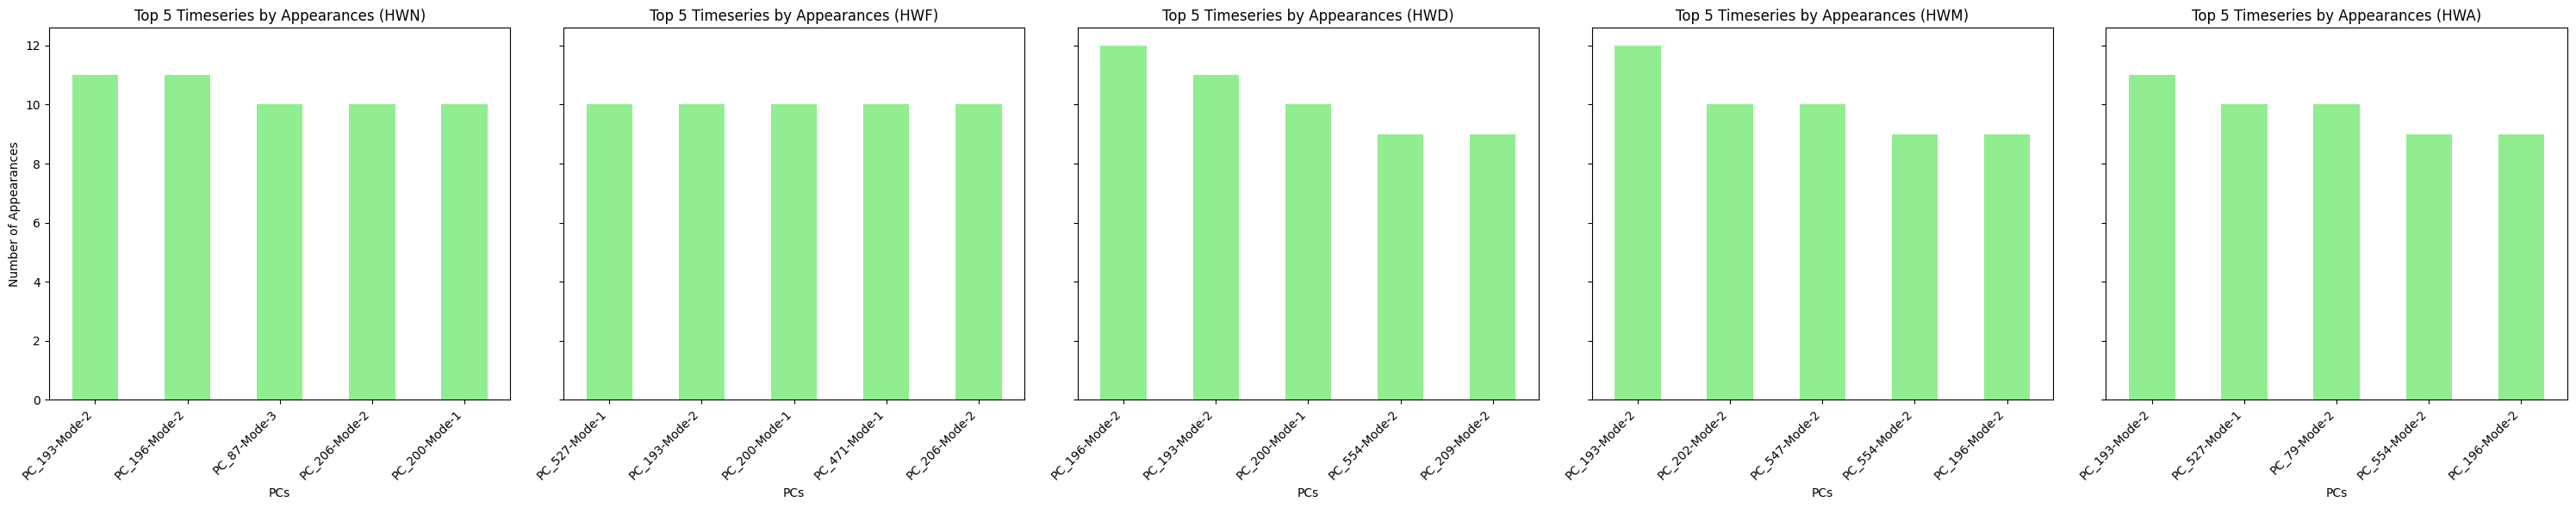

In [216]:
# Initialize a dictionary to store counts for each index
index_counts = {}

# Iterate over each index and count appearances
for index in indices_of_interest:
    # Filter the DataFrame for the current index
    index_df = all_correlations_df[all_correlations_df['Index'] == index]
    # Count the frequency of each timeseries in the 'Timeserie' column
    index_counts[index] = index_df['PC'].value_counts()

# Get the top 20 timeseries for each index
top_20_index_counts = {
    index: counts.head(5) for index, counts in index_counts.items()
}

# Plot the top 20 timeseries for each index
fig, axes = plt.subplots(1, 5, figsize=(30, 6), sharey=True)

for i, index in enumerate(indices_of_interest):
    ax = axes[i]
    if index in top_20_index_counts:
        top_20_index_counts[index].plot(kind='bar', color='lightgreen', ax=ax)
        ax.set_title(f'Top 5 Timeseries by Appearances ({index})')
        ax.set_xlabel('PCs')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Number of Appearances')

plt.tight_layout()
plt.show()


### Average

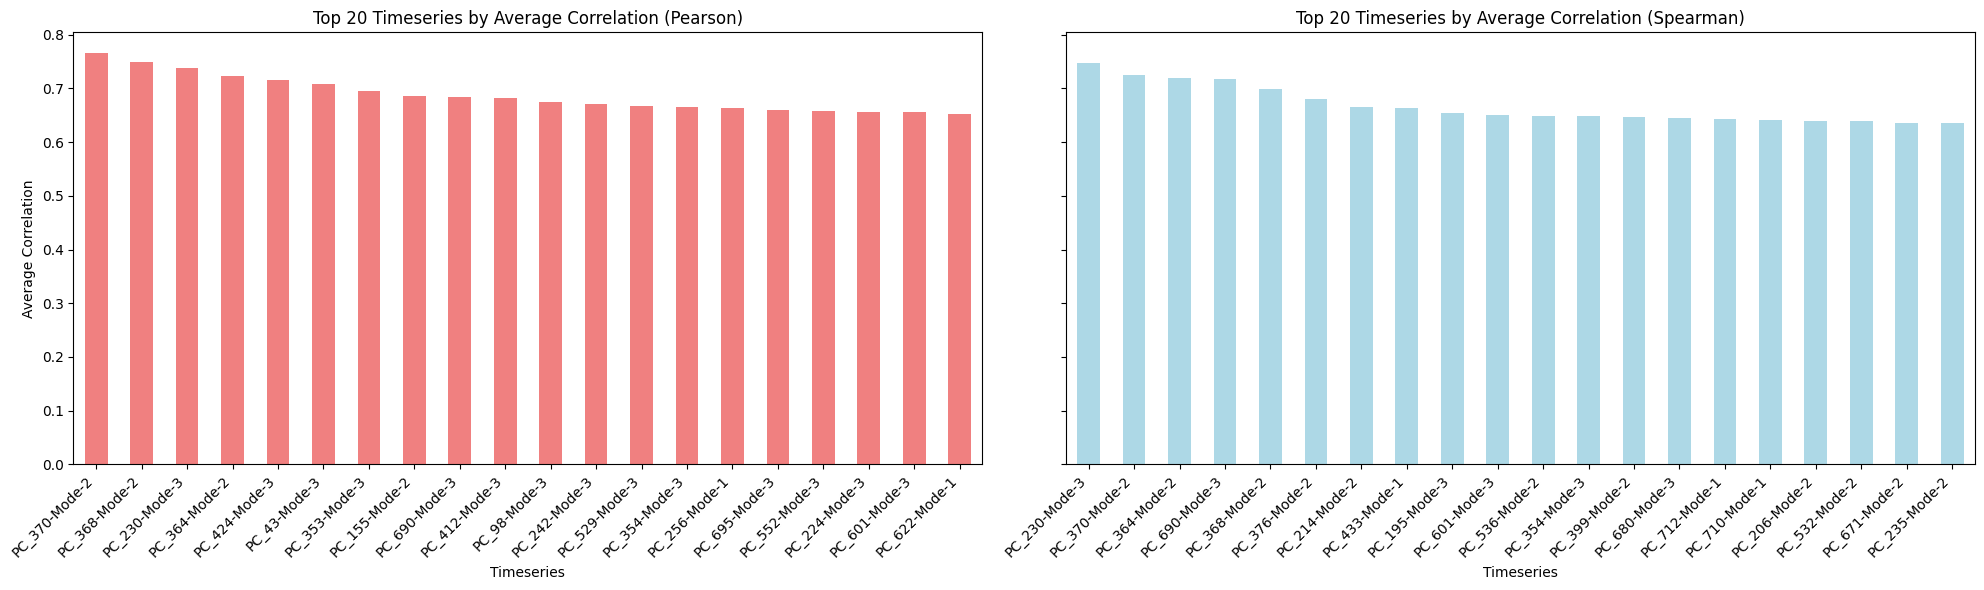

In [217]:
# Initialize a dictionary to store average correlations for each method
methods = ["pearson", "spearman"]
method_avg_correlation = {}

for method in methods:
    # Filter the DataFrame for the current method
    method_df = all_correlations_df[all_correlations_df['Method'] == method]
    # Calculate the average correlation for each timeseries
    method_avg_correlation[method] = method_df.groupby('PC')['Correlation'].mean().sort_values(ascending=False)

# Get the top 20 timeseries by average correlation for each method
top_20_avg_correlation = {
    method: correlations.head(20) for method, correlations in method_avg_correlation.items()
}

# Plot the top 20 timeseries by average correlation for each method
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

for i, method in enumerate(methods):
    ax = axes[i]
    top_20_avg_correlation[method].plot(kind='bar', color='lightcoral' if method == "pearson" else 'lightblue', ax=ax)
    ax.set_title(f'Top 20 Timeseries by Average Correlation ({method.capitalize()})')
    ax.set_xlabel('Timeseries')
    ax.set_ylabel('Average Correlation')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

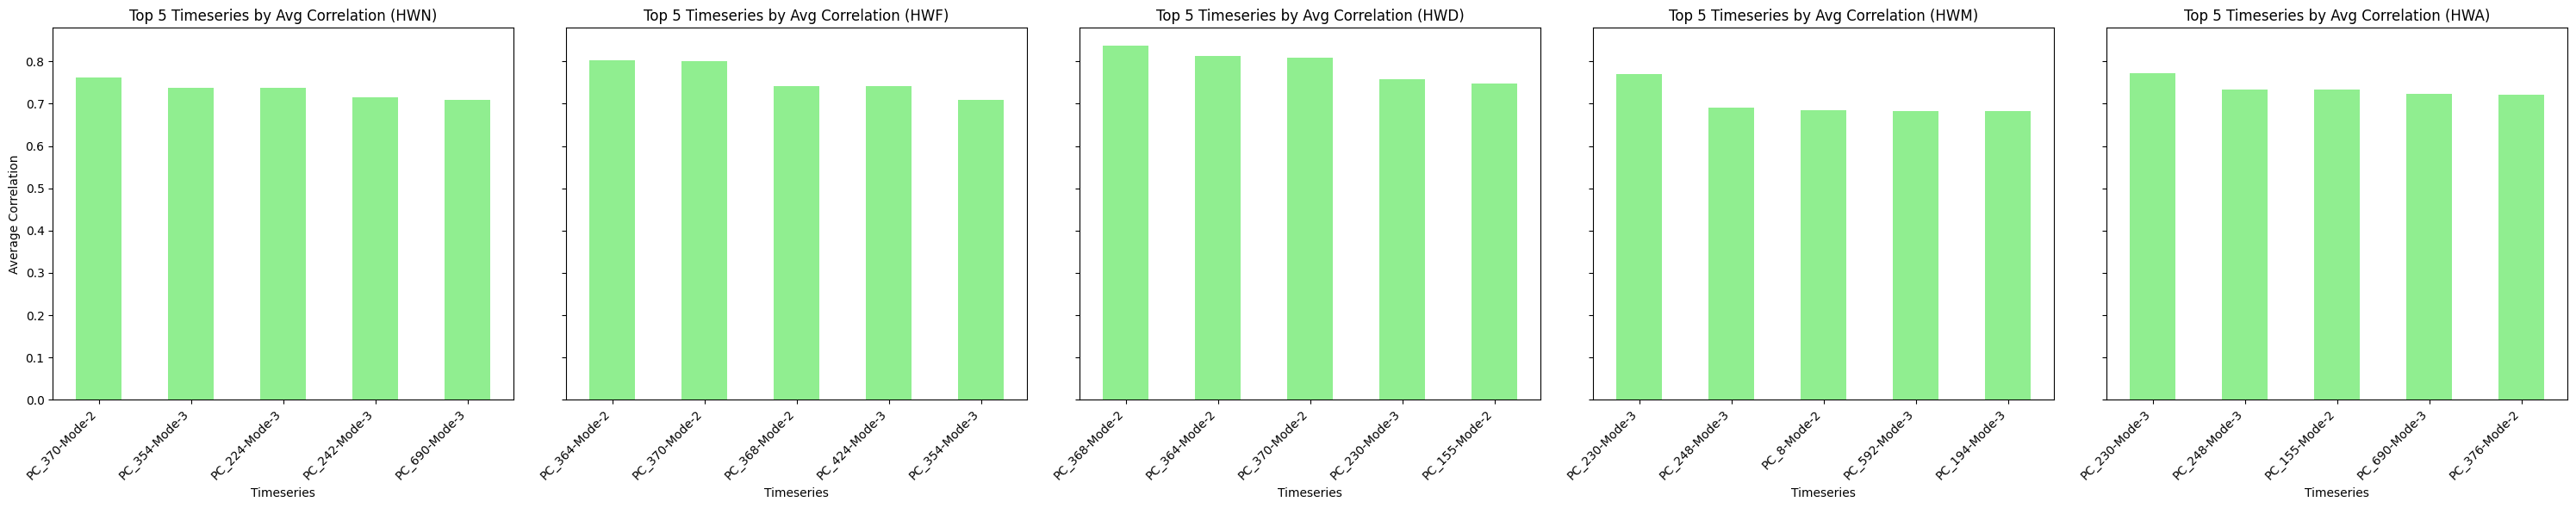

In [218]:
index_avg_correlation = {}

# Iterate over each index and compute average correlation
for index in indices_of_interest:
    # Filter the DataFrame for the current index
    index_df = all_correlations_df[all_correlations_df['Index'] == index]
    # Calculate the average correlation for each timeseries
    index_avg_correlation[index] = index_df.groupby('PC')['Correlation'].mean().sort_values(ascending=False)

# Get the top 20 timeseries by average correlation for each index
top_20_index_avg_correlation = {
    index: correlations.head(5) for index, correlations in index_avg_correlation.items()
}

# Plot the top 20 timeseries by average correlation for each index
fig, axes = plt.subplots(1, 5, figsize=(30, 6), sharey=True)

for i, index in enumerate(indices_of_interest):
    ax = axes[i]
    if index in top_20_index_avg_correlation:
        top_20_index_avg_correlation[index].plot(kind='bar', color='lightgreen', ax=ax)
        ax.set_title(f'Top 5 Timeseries by Avg Correlation ({index})')
        ax.set_xlabel('Timeseries')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Average Correlation')

plt.tight_layout()
plt.show()

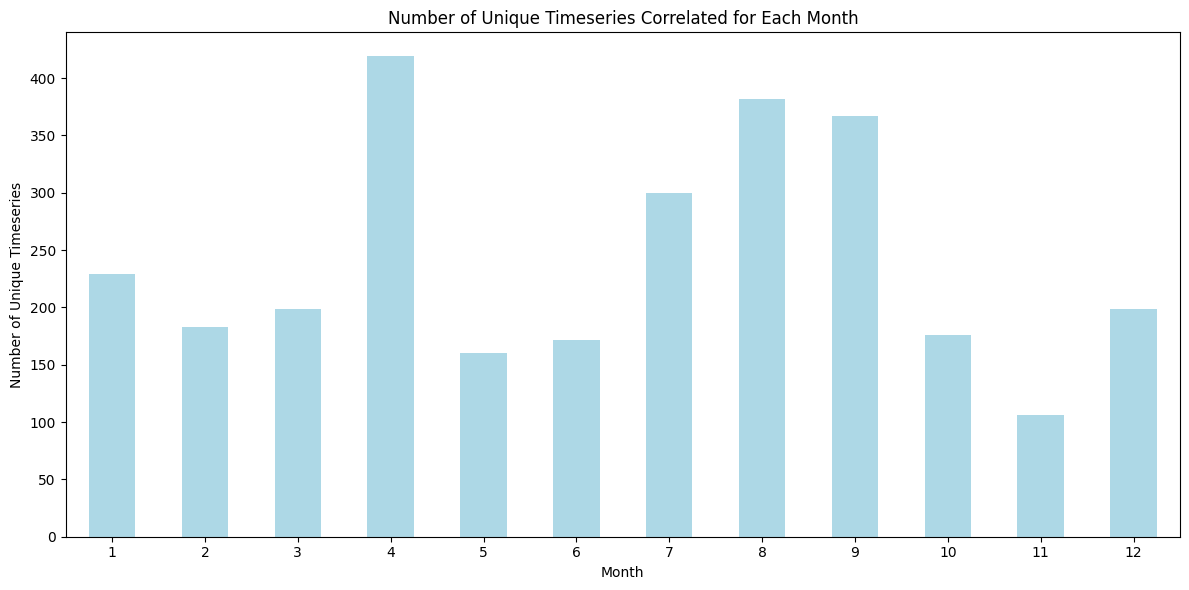

In [127]:
# Create a DataFrame to count unique timeseries appearances per month
unique_month_counts = all_correlations_df.groupby(['Season', 'PC']).size().reset_index(name='Count')

# Set 'Count' to 1 to represent a unique appearance per timeseries per month
unique_month_counts['Count'] = 1

# Sum the number of unique timeseries for each month
timeseries_per_month = unique_month_counts.groupby('Season')['Count'].sum()

# Plot the number of timeseries that appear correlated for each month
plt.figure(figsize=(12, 6))
timeseries_per_month.plot(kind='bar', color='lightblue')
plt.title('Number of Unique Timeseries Correlated for Each Month')
plt.xlabel('Month')
plt.ylabel('Number of Unique Timeseries')
plt.xticks(rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

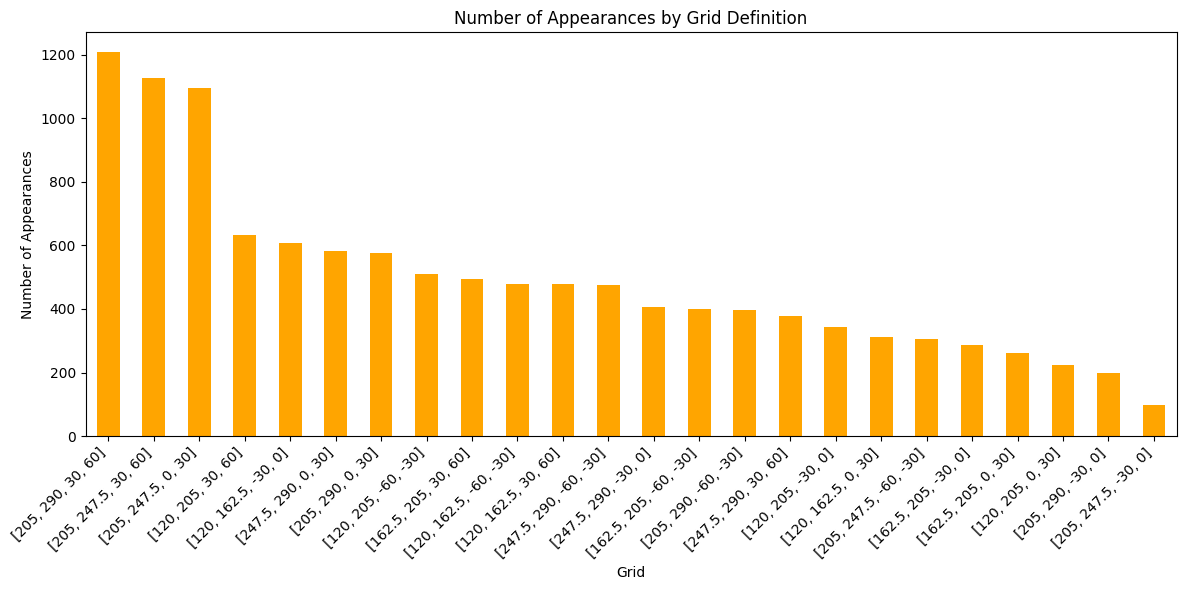

In [128]:

# Extract the 'grid' information for each timeseries ID in `all_correlations_df`
all_correlations_df['Grid'] = all_correlations_df['ID'].map(lambda ts_id: pcas[int(ts_id)].box)

# Count the number of times each grid appears in the correlations DataFrame
grid_counts = all_correlations_df['Grid'].value_counts()

# Plot the counts of appearances for each grid
plt.figure(figsize=(12, 6))
grid_counts.plot(kind='bar', color='orange')
plt.title('Number of Appearances by Grid Definition')
plt.xlabel('Grid')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

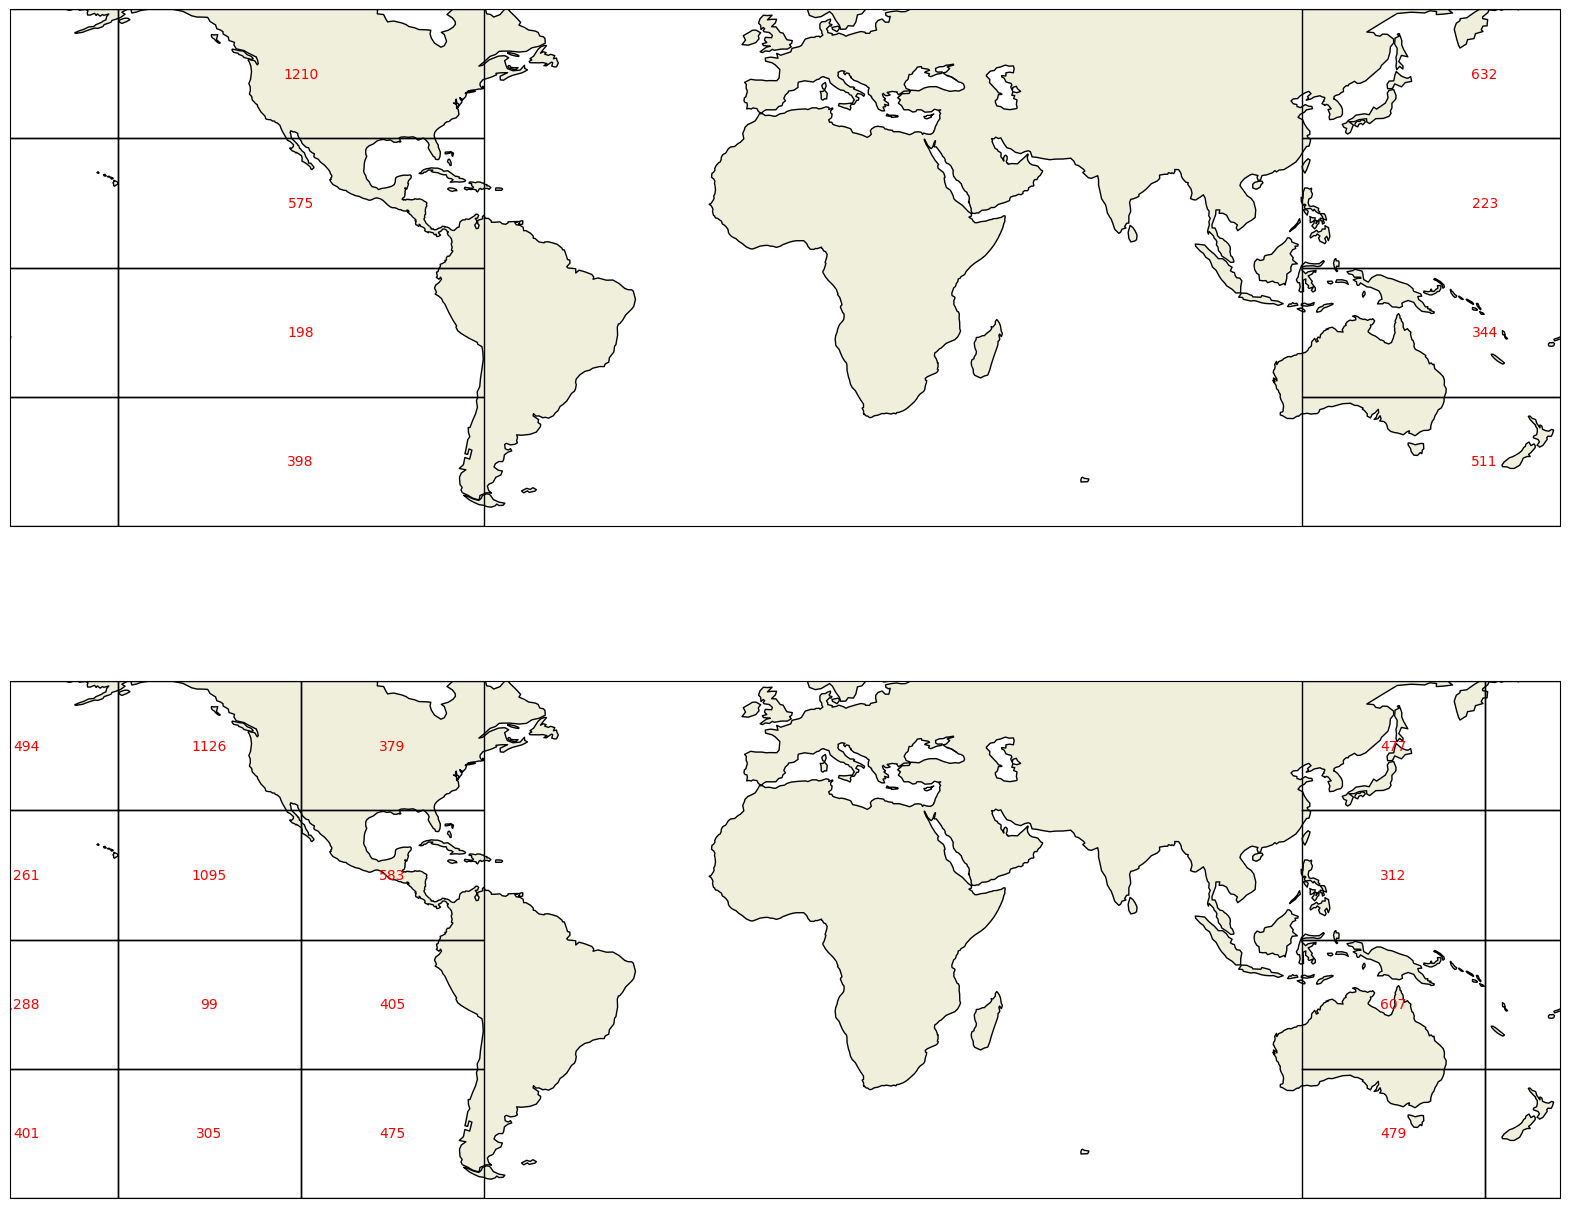

In [129]:
# Create a figure and axis
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())

# Set map extent
ax.set_extent([120, 290, -60, 60], crs=ccrs.PlateCarree())

# Add land and coastlines
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

# Plot the boxes and their counts
for grid, count in grid_counts.items():
    if grid in boxes1.values():
        min_lon, max_lon, min_lat, max_lat = grid
        
        ax.plot([min_lon, max_lon, max_lon, min_lon, min_lon],
                [min_lat, min_lat, max_lat, max_lat, min_lat],
                color='black', linewidth=1, transform=ccrs.PlateCarree())
        ax.text((min_lon + max_lon) / 2, (min_lat + max_lat) / 2,
                str(count),
                horizontalalignment='center',
                verticalalignment='center',
                transform=ccrs.PlateCarree(), color="r")
        

ax2.set_extent([120, 290, -60, 60], crs=ccrs.PlateCarree())

# Add land and coastlines
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.COASTLINE)

# Plot the boxes and their counts
for grid, count in grid_counts.items():
    if grid in boxes2.values():
        min_lon, max_lon, min_lat, max_lat = grid
        
        ax2.plot([min_lon, max_lon, max_lon, min_lon, min_lon],
                [min_lat, min_lat, max_lat, max_lat, min_lat],
                color='black', linewidth=1, transform=ccrs.PlateCarree())
        ax2.text((min_lon + max_lon) / 2, (min_lat + max_lat) / 2,
                str(count),
                horizontalalignment='center',
                verticalalignment='center',
                transform=ccrs.PlateCarree(), color="r")

plt.show()

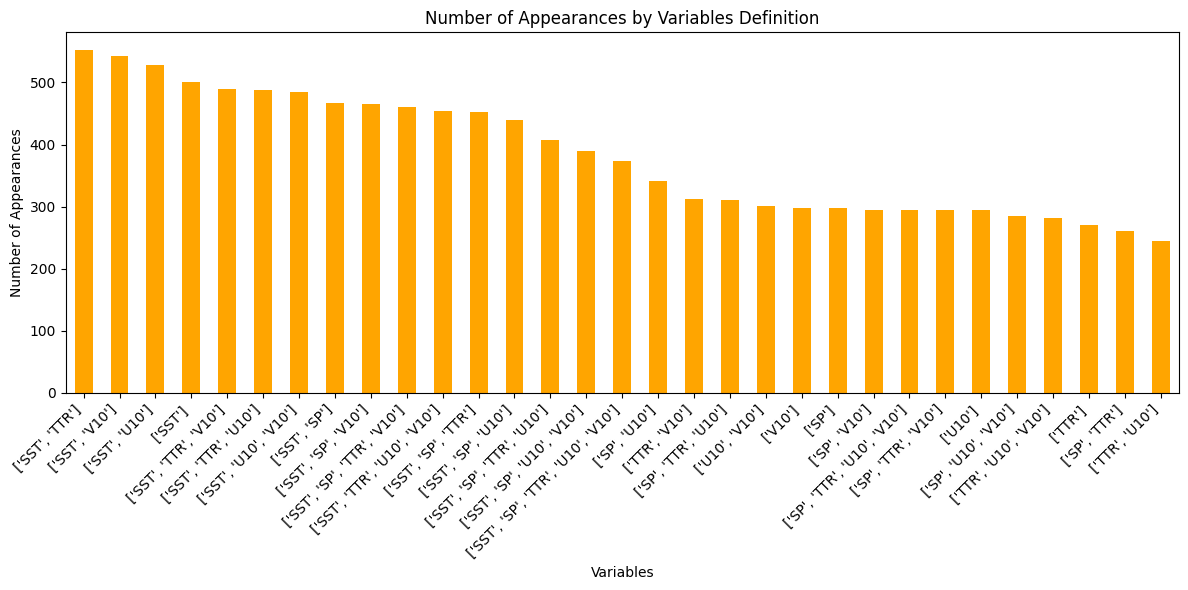

In [130]:

# Extract the 'grid' information for each timeseries ID in `all_correlations_df`
all_correlations_df['Variables'] = all_correlations_df['ID'].map(lambda ts_id: str(list(pcas[int(ts_id)].variables_dict.values())))

# Count the number of times each grid appears in the correlations DataFrame
variables = all_correlations_df['Variables'].value_counts()

# Plot the counts of appearances for each grid
plt.figure(figsize=(12, 6))
variables.plot(kind='bar', color='orange')
plt.title('Number of Appearances by Variables Definition')
plt.xlabel('Variables')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

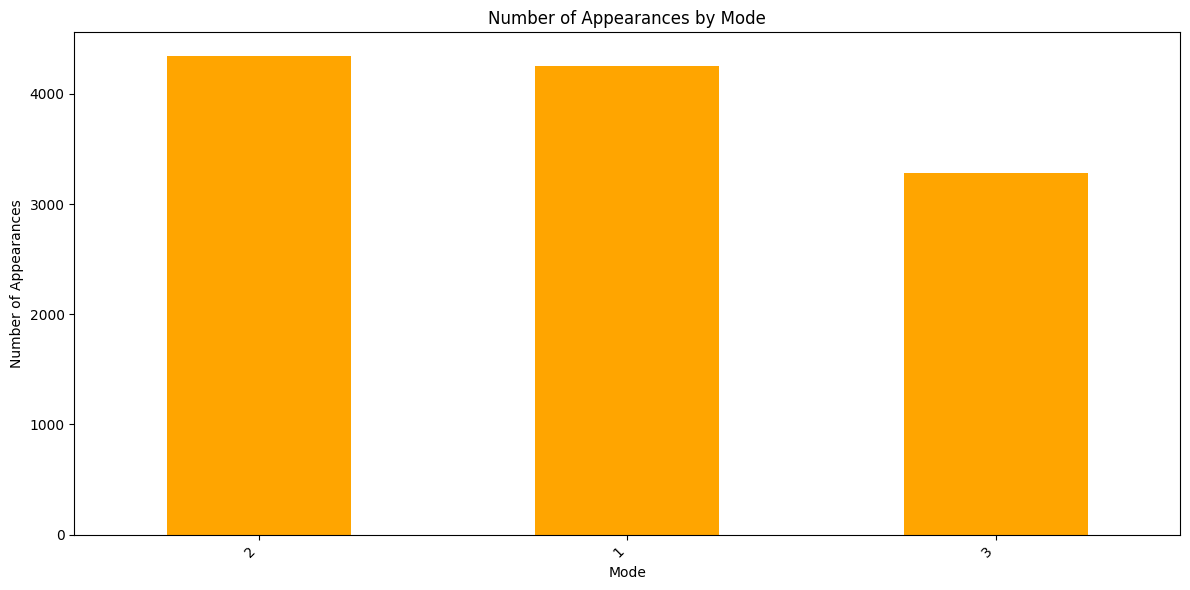

In [131]:

# Extract the 'grid' information for each timeseries ID in `all_correlations_df`
all_correlations_df['Mode'] = all_correlations_df['PC'].map(lambda pc_str: int(pc_str[-1]))

# Count the number of times each grid appears in the correlations DataFrame
modes = all_correlations_df['Mode'].value_counts()

# Plot the counts of appearances for each grid
plt.figure(figsize=(12, 6))
modes.plot(kind='bar', color='orange')
plt.title('Number of Appearances by Mode')
plt.xlabel('Mode')
plt.ylabel('Number of Appearances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()